# ML in Cybersecurity: Project II

## Team
  * **Team name**:  *fill this in*
  * **Members**:  *fill this in. format: name1 (email1), name2 (email2), ...*
  * **Tutor**: *fill this in*


## Logistics
  * **Due date**: 9th December 2018, 23:59:59 (to email the completed notebook to your respective tutors). We deduct 25% points for late submissions.
  * Complete this in the previously established **teams of 3**
  * Each team will be assigned a tutor. Mail the notebook (**do NOT share a link**) to the respective TAs before the due date.
  
  
## Timeline
  * 19-Nov-2018: Project 2 hand-out
  * **09-Dec-2018** (23:59:59): Email completed notebook to respective TAs
  * **10-Dec-2018** (12:15-14:00, regular tutorial slot): Teams present their projects
  * 17-Dec-2018 (12:15-14:00, regular tutorial slot): Project 2 discussion and summary
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.
 
We will evaluate this criteria in a presentation as for project 1. This will be during the regular tutorial slot on 10th December 12:00-14:00 (same location as last time). In case you have time restrictions during the time of the tutorial, notify us asap!  You can present on your laptops.
 
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [0]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [3]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
!pip install -q keras
!pip install cleverhans
import keras
from keras import backend as K
# In case you want to use neural networks, we only support sklearn and keras (With a tensorflow backend).

    100% |████████████████████████████████| 143kB 8.8MB/s 
    100% |████████████████████████████████| 163kB 13.8MB/s 
    100% |████████████████████████████████| 71kB 21.0MB/s 
  Running setup.py bdist_wheel for cleverhans ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/de/34/ba6eb751a29b7e111005a8ba4059fdea93275605c0531024f4
Successfully built cleverhans


Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [0]:
path='/content/gdrive/My Drive/'

def write_logs(data,f):
  fname=path+f
  with open(fname,'w') as fh:
    json.dump(data,fh)

def read_logs(f):
  fname=path+f
  with open(fname,'r') as fh:
    data=json.load(fh)
    
  return data


    
def stitch_images(images, y_img_count, x_img_count, margin = 2):
    
    # Dimensions of the images
    img_width = images[0].shape[0]
    img_height = images[0].shape[1]
    
    width = y_img_count * img_width + (y_img_count - 1) * margin
    height = x_img_count * img_height + (x_img_count - 1) * margin
    stitched_images = np.zeros((width, height, 3))

    # Fill the picture with our saved filters
    for i in range(y_img_count):
        for j in range(x_img_count):
            img = images[i * x_img_count + j]
            if len(img.shape) == 2:
                img = np.dstack([img] * 3)
            stitched_images[(img_width + margin) * i: (img_width + margin) * i + img_width,
                            (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

    return stitched_images


# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Cleverhans library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from your last project.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from your last project here and train it until it achieves reasonable accuracy (>92%).

In [6]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from random import randint


# Set random seed
np.random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train.shape = {},  y_train.shape = {}'.format(x_train.shape, y_train.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

x_train_plt = x_train
y_train_labels=y_train

im_size = 784 # 28 x 28
# building the input vector from the 28x28 pixels
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalizing the data to help with the training
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices with one-hot encoding
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train.shape = {},  y_train.shape = {}'.format(x_train.shape, y_train.shape))
print('x_test.shape = {},  y_test.shape = {}'.format(x_test.shape, y_test.shape))

#
# Feel free to have multiple variables in case your models are designed for different formats
# For instance, in case your model requires Nx28x28 inputs, declare x_trainval_3d, etc.

# Tip: Set this to a tiny number (such 0.05) to aid debugging
# After all, you do not want to train/evaluate on the entire dataset to find bugs
DEBUG_FRAC = 0.05
# Resample x_[], y_[]

11501568/11490434 [==============================] - 3s 0us/step
x_train.shape = (60000, 28, 28),  y_train.shape = (60000,)
x_test.shape = (10000, 28, 28),  y_test.shape = (10000,)
x_train.shape = (60000, 28, 28, 1),  y_train.shape = (60000, 10)
x_test.shape = (10000, 28, 28, 1),  y_test.shape = (10000, 10)


In [0]:
batch_size=128
epochs_exp=10
epochs_full=50

def build_model(params,opt='adam'):
  model = Sequential()
  k=(params['kernel_size'],params['kernel_size'])
  p=(params['pool'],params['pool'])
  c=params['conv']
  model.add(Conv2D(c, k, activation='relu',padding='same', input_shape=x_train.shape[1:]))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=p))
  model.add(Conv2D(c*2, k ,activation='relu', padding='same'))
  model.add(BatchNormalization(axis=-1))
  model.add(MaxPooling2D(pool_size=p))
  model.add(Dropout(params['drop1'])) 

  model.add(Flatten())
  model.add(Dense(params['fc_size'], activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(params['drop2']))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=params['lr']), metrics=['accuracy'])
  
  return model

def train(model, batch_size=128, epochs=5):
#   model.summary()
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.2, verbose=True)
  return history

def evaluate(model):
  loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
  print('Test loss: ',loss)
  print('Test accuracy: ',accuracy)
  

In [0]:
params={'conv': 32, 'fc_size': 128, 'kernel_size': 3, 'lr': 0.001, 'pool': 2, 'drop1':0.25, 'drop2':0.25}
# m=build_model(params)
# h=train(m,epochs=10)
# write_logs(h.history,'CNN.json')

In [0]:
# model_json = m.to_json()
# with open(path+"model.json", "w") as json_file:
#     json_file.write(model_json)
# m.save_weights(path+'cnn.h5')


In [9]:
model=None
with open(path+'model.json', 'r') as fh:
    model = fh.read()

cnn = keras.models.model_from_json(model)
# load weights into new model
cnn.load_weights(path+"cnn.h5")
cnn.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=params['lr']), metrics=['accuracy'])

evaluate(cnn)

('Test loss: ', 0.03249252149352978)
('Test accuracy: ', 0.9911)


### 1.1.2: Implementing an attack (20 Points)

We now want you to attack the model trained in the previous step. You are free to choose any attack from the lecture, or implement your own idea. Take into account that the attacker is stealthy and wants to remain undetected: introduce a small change only! To test your attack, chose one sample for each class (for example the first when iterating the test data) and visualize your (ten) crafted examples.

#
#
# ------- Your Code -------
#
#

In [0]:
import tensorflow as tf

def get_grad(model,y,x):
  grads = K.gradients(model.output, model.input)[0]
  # normalization
#   grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input], [model.output, grads])
  sess.run(tf.initialize_all_variables())
  evaluated_gradients = sess.run(grads,feed_dict={cnn.input:np.reshape(x, (-1, 28, 28, 1))})
  return evaluated_gradients
  
  
def jsma(sess,model, x, yind, epochs, eps, clip_min=0.0, clip_max=1.0, score_fn=lambda t, o: t * tf.abs(o)):
    i=0
    xadv=np.copy(x)
    while(i<epochs):
#     def _cond(i,xadv):
#         return i<epochs

#     def _body(i, xadv):
        print('predicting')
        ybar = np.argmax(model.predict(xadv),axis=1)

        dy_dx = get_grad(model,ybar, xadv)
        print(dy_dx)

        # gradients of target w.r.t input
        yt = K.gather(ybar, yind)
        dt_dx = get_grad(model,yt, xadv)

        # gradients of non-targets w.r.t input
        do_dx = dy_dx - dt_dx

        c0 = K.any(eps < 0, xadv < clip_max)
        c1 = K.any(eps > 0, xadv > clip_min)
        cond = K.all([dt_dx >= 0, do_dx <= 0, c0, c1], axis=0)
        cond = K.cast_to_floatx(cond)

        # saliency score for each pixel
        score = cond * score_fn(dt_dx, do_dx)

        shape = score.shape
        dim = K.prod(shape[1:])
        score = K.reshape(score, [-1, dim])

        # pixel with the highest saliency score
        ind = np.argmax(score, axis=1)
        dx = K.one_hot(ind, dim, on_value=eps, off_value=0.0)
        dx = K.reshape(dx, [-1] + shape[1:])

        xadv = K.stop_gradient(xadv + dx)
        xadv = K.clip(xadv, clip_min, clip_max)

        i=i+1
#     _, xadv = tf.while_loop(_cond, _body, (0, x[0]), back_prop=False, name='jsma_batch')

    return xadv


In [0]:
def make_jsma(sess, X_data, y,epochs=0.2, eps=1.0, batch_size=128):
    
    print('\nMaking adversarials using JSMA')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)
    targets=np.argmax(y,axis=1)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch))
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
#         sess.run(x)
        adv=jsma(sess,cnn, X_data, targets, eps=eps, epochs=epochs)
        X_adv[start:end] = adv
    print()

    return X_adv

In [41]:
x = x_test[:10]
y = y_test[:10]
adv_epochs = 20
adv_eps = 0.2
K.set_learning_phase(False)
sess =  K.get_session()
xadv=make_jsma(sess,x,y,epochs=adv_epochs,eps=adv_eps)



Making adversarials using JSMA
 batch 1/1
predicting
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
 

ValueError: ignored

In [0]:

# K.set_learning_phase(False)
# sess =  K.get_session()
# # with tf.Session(graph=sess.graph) as session:
# #     session.run(tf.global_variables_initializer())

# X_adv = make_jsma(sess, env, x_test, epochs=30, eps=1.0)



**after this is all experimental, dont copy**

In [97]:
layer_dict = dict([(layer.name, layer) for layer in cnn.layers])
print(layer_dict)

{u'dense_2': <keras.layers.core.Dense object at 0x7fc3c07209d0>, u'dense_1': <keras.layers.core.Dense object at 0x7fc3c072b850>, u'flatten_1': <keras.layers.core.Flatten object at 0x7fc3c076b9d0>, u'max_pooling2d_1': <keras.layers.pooling.MaxPooling2D object at 0x7fc3c1109b10>, u'max_pooling2d_2': <keras.layers.pooling.MaxPooling2D object at 0x7fc3c1064210>, u'dropout_1': <keras.layers.core.Dropout object at 0x7fc3c076ba50>, u'dropout_2': <keras.layers.core.Dropout object at 0x7fc3c0720250>, u'batch_normalization_2': <keras.layers.normalization.BatchNormalization object at 0x7fc3c10f0c10>, u'batch_normalization_3': <keras.layers.normalization.BatchNormalization object at 0x7fc3c0701a90>, u'batch_normalization_1': <keras.layers.normalization.BatchNormalization object at 0x7fc3c1109b90>, u'conv2d_1': <keras.layers.convolutional.Conv2D object at 0x7fc3c1109990>, u'conv2d_2': <keras.layers.convolutional.Conv2D object at 0x7fc3c1105810>}


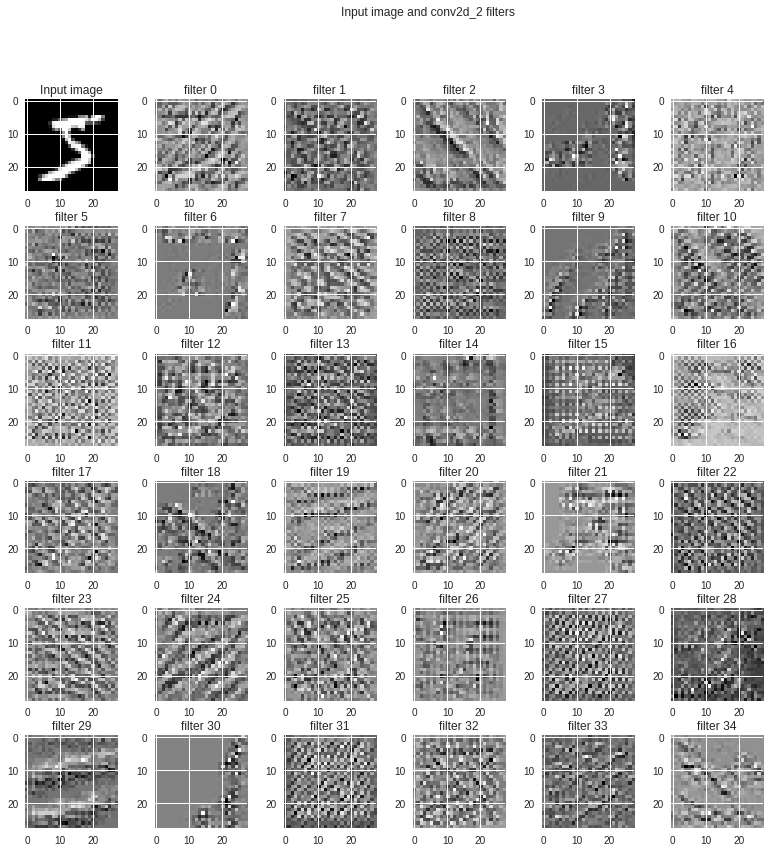

In [99]:

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_2',model=cnn):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()

In [0]:
class SalMask(object):
    def __init__(self, model, output_index=0):
        pass

    def get_mask(self, input_image):
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=50):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image, dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += self.get_mask(x_value_plus_noise)

        return total_gradients / nsamples

In [0]:
class GradSal(SalMask):
  def __init__(self, model, output_index=0):
    input_tensors = [model.input]
    gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
    self.compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

  def get_mask(self, input_image):
    # Execute the function to compute the gradient
    x_value = np.expand_dims(input_image, axis=0)
    gradients = self.compute_gradients([x_value])[0][0]

    return gradients
#     outputTensor = model.predict(x)
#     listOfVariableTensors = model.inputs
#     grads = K.gradients(outputTensor,listOfVariableTensors)[0]
#     evaluated_gradients = K.function([x],[outputTensor,grads])
# #     grads = np.reshape(grads, (-1, nb_features))[0]
#     dy_dx=evaluated_gradients(x)
  
#   # Remove gradients for already used features
#     used_features = list(set(range(nb_features)) - search_space)
#     coeff = 2 * int(theta > 0) - 1
#     dy_dx[used_features] = -np.inf * coeff

#     if theta > 0:
#         ind = np.argpartition(dy_dx, -2)[-2:]
#     else:
#         ind = np.argpartition(-dy_dx, -2)[-2:]

#     return tuple(ind)

In [0]:
def random_targets(labels,num_classes):
  
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)

    y_rand = np.zeros(labels.shape)

    for class_ind in range(num_classes):
        other_classes = list(range(num_classes))
        other_classes.remove(class_ind)
        in_cl = labels == class_ind
        y_rand[in_cl] = np.random.choice(other_classes)
    
    y_rand = keras.utils.to_categorical(y_rand, num_classes)

    return y_rand


def jsma(model, x, y=None, theta=1, gamma=0.5, clip_min=0.0, clip_max=1.0):
       
    sess=K.get_session()
    # Initialize variables
    dims = [1] + list(x.shape[1:])
    nb_features = np.product(dims)
    x_adv = np.reshape(np.copy(x), (-1, nb_features))
    preds = np.argmax(model.predict(x), axis=1)

    # Determine target classes for attack
    if y is None:
        targets = np.argmax(random_targets(preds, num_classes), axis=1)
    else:
        targets = np.argmax(y, axis=1)

    # Generate the adversarial samples
    for ind, val in enumerate(x_adv):
        # Initialize the search space; optimize to remove features that can't be changed
        if theta > 0:
            search_space = set([i for i in range(nb_features) if val[i] < clip_max])
        else:
            search_space = set([i for i in range(nb_features) if val[i] > clip_min])

        current_pred = preds[ind]
        target = targets[ind]
        all_feat = set()

        while current_pred != target and len(all_feat) / nb_features <= gamma and bool(search_space):
            # Compute saliency map
            feat1, feat2 = saliency_map(sess,model, np.reshape(val, dims), target, theta, nb_features, search_space)

            # Move on to next examples if there are no more features to change
            if feat1 == feat2 == 0:
                break

            all_feat = all_feat.union(set([feat1, feat2]))

            # Prepare update depending of theta
            if theta > 0:
                clip_func, clip_value = np.minimum, clip_max
            else:
                clip_func, clip_value = np.maximum, clip_min

            # Update adversarial example
            for feature_ind in [feat1, feat2]:
                val[feature_ind] = clip_func(clip_value, val[feature_ind] + theta)

                # Remove indices from search space if max/min values were reached
                if val[feature_ind] == clip_value:
                    search_space.discard(feature_ind)

            # Recompute model prediction
            current_pred = np.argmax(model.predict(np.reshape(val, dims)), axis=1)

    x_adv = np.reshape(x_adv, x.shape)
    preds = np.argmax(model.predict(x), axis=1)
    preds_adv = np.argmax(model.predict(x_adv), axis=1)
    logger.info('Success rate of JSMA attack: %.2f%%', (np.sum(preds != preds_adv) / x.shape[0]))

    return x_adv

In [92]:
xadv=jsma(cnn,x_test[:10])

TypeError: ignored

In [133]:
sess =  K.get_session()
outputTensor = cnn.predict(x)
listOfVariableTensors = cnn.inputs[0]
gradients = K.gradients(outputTensor, listOfVariableTensors)
sess.run(tf.initialize_all_variables())
evaluated_gradients = sess.run(gradients,feed_dict={cnn.input:np.reshape(x_test[0], (-1, 28, 28, 1))})
evaluated_gradients

ValueError: ignored

In [13]:

cat_y=np.argmax(y_test,axis=1)
candidates={i:[] for i in range(num_classes)}
for i,l in enumerate(cat_y):
  if candidates[l]==[]:
    candidates[l]=x_test[i]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """


In [0]:
def pick_adv(label):
  for i,l in enumerate(cat_y):
    if label!=l:
      return x_test[i],l
      

In [19]:
adv,t=pick_adv(0)
print t

7


In [0]:
def gen(samples):
  for label,candidate in samples.iteritems():
#   candidate=x_test[0]
#   label=np.argmax([y_test[0]],axis=1)
    l=label
  #   random=x_test[100]
  #   target_label=np.argmax([y_test[100]],axis=1)
    adv=[]
    pred=[]
    adv,t=pick_adv(label)
    diff=candidate-adv
    eps=0.1
    while l==label:

      new=candidate+eps*diff
      new=np.clip(new,0.0,1.0)
      l=np.argmax(cnn.predict(np.reshape(new,(-1,28,28,1))),axis=1)
    print(label,l)
    adv.append(new)
    pred.append(l)
  return adv,pred
  

In [0]:
adv,pred=gen({0:candidates[0]})

(array([7]), array([6]), array([1]))


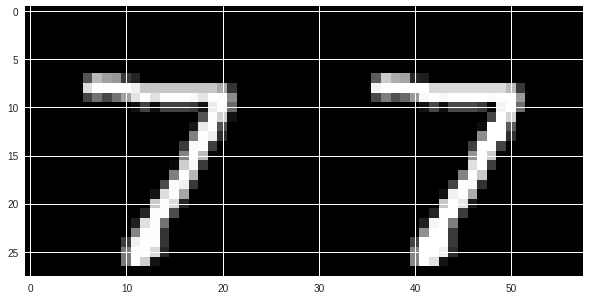

In [62]:
candidate=x_test[0]
label=np.argmax([y_test[0]],axis=1)
l=label
random=x_test[100]
target_label=np.argmax([y_test[100]],axis=1)
diff=candidate-random
eps=0.1
while l==label:

  new=candidate+eps*diff
  new=np.clip(new,0.0,1.0)
  l=np.argmax(cnn.predict(np.reshape(new,(-1,28,28,1))),axis=1)
print(label,l)


print(label,target_label,l)
comparison=stitch_images([candidate.reshape(28,28),new.reshape(28,28)],1,2)
plt.imshow(comparison)
plt.show()

### 1.1.3: Visualizing the results (5 Points)

Please visualize the ten adversarial examples you crafted in the previous step.

In [0]:
#
#
# ------- Your Code and plots-------
#
#

### 1.2.1: Using libraries for attacks (20 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the CleverHans (https://github.com/tensorflow/cleverhans) library. Please implement FGSM and another attack of your choice using this library. Please plot for both attacks the resulting adversarial examples (using the same test instances as before). Please additionally craft a bigger set of at least 1,000 examples using FGSM for your defense. 

In [0]:
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.utils_keras import KerasModelWrapper

In [12]:
K.set_learning_phase(False)
sess =  K.get_session()

# Initialize the Fast Gradient Sign Method (FGSM) attack object and 
# use it to create adversarial examples as numpy arrays.
wrap = KerasModelWrapper(cnn)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
               'clip_min': 0.,
               'clip_max': 1.}
adv_x = fgsm.generate_np(x_test, **fgsm_params)

adv_pred = np.argmax(cnn.predict(adv_x), axis = 1)
adv_pred=keras.utils.to_categorical(adv_pred, num_classes)
adv_acc =  np.mean(np.equal(adv_pred, y_test))

print("The adversarial validation accuracy is: {}".format(adv_acc))

[INFO 2018-12-09 10:58:01,564 cleverhans] Constructing new graph for attack FastGradientMethod


The adversarial validation accuracy is: 0.82176


In [11]:
adv_x.shape

(10000, 28, 28, 1)

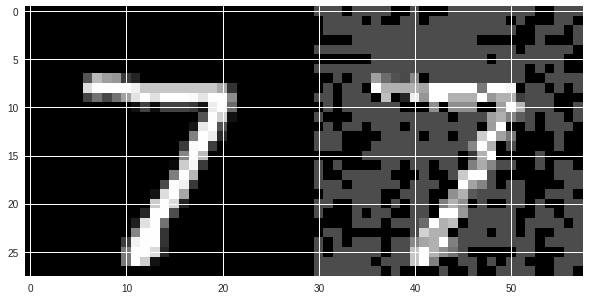

In [0]:
x_sample = x_test[0].reshape(28, 28)
adv_x_sample = adv_x[0].reshape(28, 28)

adv_comparison = stitch_images([x_sample, adv_x_sample], 1, 2)

plt.imshow(adv_comparison)
plt.show()

In [0]:
# bim = BasicIterativeMethod(wrap, sess=sess)
# bim_params = {'eps_iter': 0.01,
#               'nb_iter': 100,
#               'clip_min': 0.,
#               'clip_max': 1.}
# adv_x = bim.generate_np(x_test, **bim_params)
# adv_conf = cnn.predict(adv_x)
# adv_pred = np.argmax(adv_conf, axis = 1)
adv_pred=keras.utils.to_categorical(adv_pred, num_classes)
adv_acc =  np.mean(np.equal(adv_pred, y_test))

# adv_list = np.split(adv_x, list(range(1,10)))
# adv_list = [img.reshape(28,28) for img in adv_list]
# adv_img = stitch_images(adv_list, 1, 10)

# plt.imshow(adv_img, cmap = 'gray')
# plt.show()

print("The adversarial classifications are: {}".format(adv_pred))
print("The adversarial classification confidences are: {}".format(adv_conf.max(axis = 1)))
print("The adversarial classification accuracy is: {}".format(adv_acc))

The adversarial classifications are: [[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The adversarial classification confidences are: [0.9999976 0.9815756 1.        ... 0.9999999 1.        1.       ]
The adversarial classification accuracy is: 0.80136


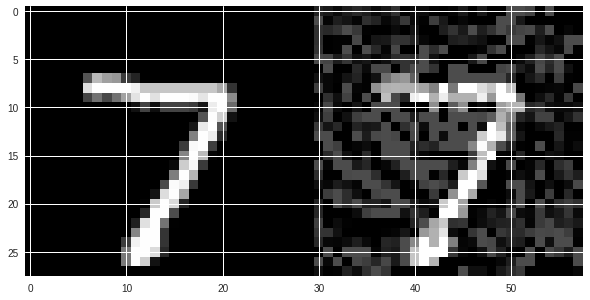

In [0]:
x_sample = x_test[0].reshape(28, 28)
adv_x_sample = adv_x[0].reshape(28, 28)

adv_comparison = stitch_images([x_sample, adv_x_sample], 1, 2)

plt.imshow(adv_comparison)
plt.show()

### 1.2.2: Visualizing the results (10 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (your own versus the new ones, FGSM versus other). Which differences do you observe? Why? 

Please write a brief summary of your findings.

In [0]:
#
#
# ------- Your Code -------
#
#

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM. You are free, however, to increase this special test set (for example by >20 examples (>10 from your attack, >10 from the second attack of the library)).

In [0]:
#
#
# ------- Your Code -------
#
#

### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. What did you try to make the classifier more robust? Why did it work? Is the classifier now robust?

Feel free to state any interesting finding you encountered during this project.